# OpenFDA → RWE Governance Scorecard (Resilient & Enriched)

This notebook fetches a sample of **OpenFDA FAERS** adverse event reports focusing on monoclonal antibodies (mAbs),
then computes **governance metrics** and renders a **scorecard**. It is hardened against FAERS 500 errors and will
fallback to cached or synthetic data so the demo **always runs**.

**What this does**
1. Robust fetch for mAbs (pagination, retries, cache, synthetic fallback) — building a `payload` shaped like OpenFDA.
2. Flatten to a tabular `df` with key columns.
3. (Optional) Enrich with **reactions** and **drugs** in wide and long forms.
4. Compute **governance metrics** and **plot** the scorecard.
5. Save artifacts: `data/openfda_sample.json` (payload) and `data/openfda_flat.csv` (table).

## 0) Path bootstrap (so `scripts/` can be imported reliably)

In [18]:
import sys, os
# If this notebook lives in notebooks/, add repo root so `scripts/` can be found
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)
print("Repo root on sys.path:", repo_root)

Repo root on sys.path: /Users/cmontefusco/global-rwe-governance-playbook


## 1) Imports

In [78]:
import os, time, json, requests, pandas as pd, numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from scripts.scorecard import compute_basic_metrics, score, plot_scorecard

pd.set_option('display.max_columns', 50)
print('Setup complete.')

Setup complete.


## 1) Fetch data from OpenFDA API

We request a small sample of **drug adverse events**. Endpoint docs: https://api.fda.gov/drug/event.json

You can change the `search` and `limit` parameters to explore different products or time windows.


In [39]:
BASE = "https://api.fda.gov/drug/event.json"
API_KEY = os.getenv("OPENFDA_API_KEY")   # optional
LIMIT = 25                               # per page (tiny to avoid 500s)
MAX_PAGES = 2                            # up to ~50 per mAb
PER_REQUEST_TIMEOUT = (5, 7)             # (connect, read) seconds
MAX_RETRIES = 2

# A small panel of commonly-reported monoclonal antibodies
MABS = [
    "PEMBROLIZUMAB","NIVOLUMAB","ATEZOLIZUMAB","DURVALUMAB","AVELUMAB",
    "RITUXIMAB","TRASTUZUMAB","BEVACIZUMAB","OCRELIZUMAB","ADALIMUMAB"
]

def fetch_for_mab(name, limit=LIMIT, max_pages=MAX_PAGES):
    rows = []
    for page in range(max_pages):
        params = {
            "search": f'patient.drug.medicinalproduct:"{name}"',
            "limit": limit,
            "skip": page * limit
        }
        if API_KEY:
            params["api_key"] = API_KEY
        attempt, backoff = 0, 0.8
        while True:
            try:
                r = requests.get(BASE, params=params, timeout=PER_REQUEST_TIMEOUT)
                if r.status_code in (429,) or r.status_code >= 500:
                    raise requests.HTTPError(f"{r.status_code} server error")
                r.raise_for_status()
                chunk = r.json().get("results", [])
                rows.extend(chunk)
                if len(chunk) < limit:
                    return rows
                break
            except Exception as e:
                attempt += 1
                if attempt >= MAX_RETRIES:
                    print(f"[warn] {name} page {page} failed after retries: {e}")
                    return rows  # keep partial if any
                time.sleep(backoff); backoff *= 2
    return rows

# Try multiple mAbs; deduplicate by safetyreportid
seen = set()
aggregated = []
for mab in MABS:
    chunk = fetch_for_mab(mab)
    for rec in chunk:
        sid = rec.get("safetyreportid")
        if sid and sid not in seen:
            seen.add(sid)
            aggregated.append(rec)

if not aggregated:
    print("[fallback] Using schema-compatible synthetic sample (OpenFDA unavailable).")
    aggregated = [
        {
            "safetyreportid": "SYN1",
            "receiptdate": "20240515",
            "receivedate": "20240516",
            "occurcountry": "US",
            "serious": "1",
            "companynumb": "ACME-001",
            "sender": {"senderorganization": "ACME PHARMA"},
            "patient": {"reaction":[{"reactionmeddrapt":"Pneumonitis"}],
                        "drug": [{"medicinalproduct": "NIVOLUMAB", "drugcharacterization":"1"}]}
        },
        {
            "safetyreportid": "SYN2",
            "receiptdate": "20240520",
            "receivedate": "20240521",
            "occurcountry": "DE",
            "serious": "0",
            "companynumb": "ACME-002",
            "sender": {"senderorganization": "ACME PHARMA"},
            "patient": {"reaction":[{"reactionmeddrapt":"Rash"}],
                        "drug": [{"medicinalproduct": "PEMBROLIZUMAB", "drugcharacterization":"1"}]}
        },
        {
            "safetyreportid": "SYN3",
            "receiptdate": "20240601",
            "receivedate": "20240602",
            "occurcountry": "GB",
            "serious": "1",
            "companynumb": "ACME-003",
            "sender": {"senderorganization": "ACME PHARMA"},
            "patient": {"reaction":[{"reactionmeddrapt":"Infusion related reaction"}],
                        "drug": [{"medicinalproduct": "RITUXIMAB", "drugcharacterization":"1"}]}
        },
    ]

payload = {"results": aggregated}
print(f"[info] payload ready with {len(payload['results'])} records")


[info] payload ready with 499 records


## 2) Normalize to a tabular view

OpenFDA returns nested JSON. We extract a few commonly available fields for governance checks.


In [41]:
results = payload.get('results', [])

def flatten(rec):
    return {
        'safetyreportid': rec.get('safetyreportid'),
        'receiptdate': rec.get('receiptdate'),
        'receivedate': rec.get('receivedate'),
        'occurcountry': rec.get('occurcountry'),
        'serious': rec.get('serious'),
        'senderorganization': rec.get('sender', {}).get('senderorganization') if isinstance(rec.get('sender'), dict) else None,
        'companynumb': rec.get('companynumb'),
    }

df = pd.DataFrame([flatten(r) for r in results])
df.head()

,safetyreportid,receiptdate,receivedate,occurcountry,serious,senderorganization,companynumb
0,10222779,20161208,20140606,DE,1,FDA-Public Use,DE-BRISTOL-MYERS SQUIBB COMPANY-20797825
1,10329852,20141104,20140721,DE,1,FDA-Public Use,DE-009507513-1405DEU014350
2,10329858,20150708,20140721,ES,1,FDA-Public Use,ES-009507513-1404ESP006276
3,10329882,20150805,20140721,US,1,FDA-Public Use,US-MERCK-1404USA003913
4,10330020,20150317,20140721,FR,1,FDA-Public Use,FR-009507513-1406FRA008549


## 3) Enrich: reactions/drugs (wide and long forms) — optional

In [43]:
def get_reactions_list(rec):
    rx = rec.get("patient", {}).get("reaction") or []
    vals = []
    for r in rx:
        if isinstance(r, dict):
            pt = r.get("reactionmeddrapt")
            if pt: vals.append(pt)
    return sorted(set(vals))

def get_drugs_list(rec):
    return [d for d in (rec.get("patient", {}).get("drug") or []) if isinstance(d, dict)]

CHAR_MAP = {1: "Primary suspect", 2: "Concomitant", 3: "Interacting"}

def primary_suspects(rec):
    ps = []
    for d in get_drugs_list(rec):
        try:
            ch = int(d.get("drugcharacterization"))
        except (TypeError, ValueError):
            ch = None
        if ch == 1:
            name = d.get("medicinalproduct") or (d.get("activesubstance") or {}).get("activesubstancename")
            if name: ps.append(name)
    return sorted(set(ps))

def all_drug_names(rec):
    names = []
    for d in get_drugs_list(rec):
        name = d.get("medicinalproduct") or (d.get("activesubstance") or {}).get("activesubstancename")
        if name: names.append(name)
    return sorted(set(names))

def get_flag(rec, key):
    v = rec.get(key)
    return 1 if str(v).strip() == "1" else 0

# Wide table
wide_rows = []
for rec in results:
    wide_rows.append({
        "safetyreportid": rec.get("safetyreportid"),
        "receiptdate": rec.get("receiptdate"),
        "receivedate": rec.get("receivedate"),
        "occurcountry": rec.get("occurcountry"),
        "senderorganization": (rec.get("sender") or {}).get("senderorganization"),
        "companynumb": rec.get("companynumb"),
        "serious": rec.get("serious"),
        "seriousnessdeath": get_flag(rec, "seriousnessdeath"),
        "seriousnesslifethreatening": get_flag(rec, "seriousnesslifethreatening"),
        "seriousnesshospitalization": get_flag(rec, "seriousnesshospitalization"),
        "seriousnessdisabling": get_flag(rec, "seriousnessdisabling"),
        "seriousnesscongenitalanomali": get_flag(rec, "seriousnesscongenitalanomali"),
        "seriousnessother": get_flag(rec, "seriousnessother"),
        "patientsex": (rec.get("patient") or {}).get("patientsex"),
        "patientonsetage": (rec.get("patient") or {}).get("patientonsetage"),
        "patientonsetageunit": (rec.get("patient") or {}).get("patientonsetageunit"),
        "reactions": "; ".join(get_reactions_list(rec))[:500],
        "primary_suspect_drugs": "; ".join(primary_suspects(rec))[:500],
        "all_drugs": "; ".join(all_drug_names(rec))[:500],
    })

df_wide = pd.DataFrame(wide_rows)

# Long-form reactions
rx_rows = []
for rec in results:
    sid = rec.get("safetyreportid")
    for r in (rec.get("patient", {}).get("reaction") or []):
        if not isinstance(r, dict):
            continue
        rx_rows.append({
            "safetyreportid": sid,
            "reactionmeddrapt": r.get("reactionmeddrapt"),
            "reactionoutcome": r.get("reactionoutcome"),
        })
reactions_df = pd.DataFrame(rx_rows).dropna(subset=["reactionmeddrapt"])

# Long-form drugs
drug_rows = []
for rec in results:
    sid = rec.get("safetyreportid")
    for d in (rec.get("patient", {}).get("drug") or []):
        if not isinstance(d, dict): 
            continue
        try:
            ch_val = int(d.get("drugcharacterization"))
        except (TypeError, ValueError):
            ch_val = None
        drug_rows.append({
            "safetyreportid": sid,
            "medicinalproduct": d.get("medicinalproduct") or (d.get("activesubstance") or {}).get("activesubstancename"),
            "drugcharacterization": ch_val,
            "drugcharacterization_label": CHAR_MAP.get(ch_val, None),
            "drugindication": d.get("drugindication"),
            "therapystartdate": d.get("therapystartdate"),
            "therapyenddate": d.get("therapyenddate"),
        })
drugs_df = pd.DataFrame(drug_rows).dropna(subset=["medicinalproduct"])

df.head(), df_wide.head(), reactions_df.head(), drugs_df.head()

(  safetyreportid receiptdate receivedate occurcountry serious  \
 0       10222779    20161208    20140606           DE       1   
 1       10329852    20141104    20140721           DE       1   
 2       10329858    20150708    20140721           ES       1   
 3       10329882    20150805    20140721           US       1   
 4       10330020    20150317    20140721           FR       1   
 
   senderorganization                               companynumb  
 0     FDA-Public Use  DE-BRISTOL-MYERS SQUIBB COMPANY-20797825  
 1     FDA-Public Use                DE-009507513-1405DEU014350  
 2     FDA-Public Use                ES-009507513-1404ESP006276  
 3     FDA-Public Use                    US-MERCK-1404USA003913  
 4     FDA-Public Use                FR-009507513-1406FRA008549  ,
   safetyreportid receiptdate receivedate occurcountry senderorganization  \
 0       10222779    20161208    20140606           DE     FDA-Public Use   
 1       10329852    20141104    20140721          

#### 4) Compute governance/quality metrics and an overall score

These are illustrative metrics only; refine as needed for your organization and data model.


In [45]:
required_fields = ['safetyreportid','receiptdate','occurcountry','serious']
metrics = compute_basic_metrics(df, required_fields)
overall = score(metrics)
metrics, overall

({'n': 499,
  'completeness': 0.9839679358717435,
  'consistency': 1.0,
  'timeliness': 0.5,
  'conformity': 1.0},
 0.7451903807615231)

## 4) Plot scorecard

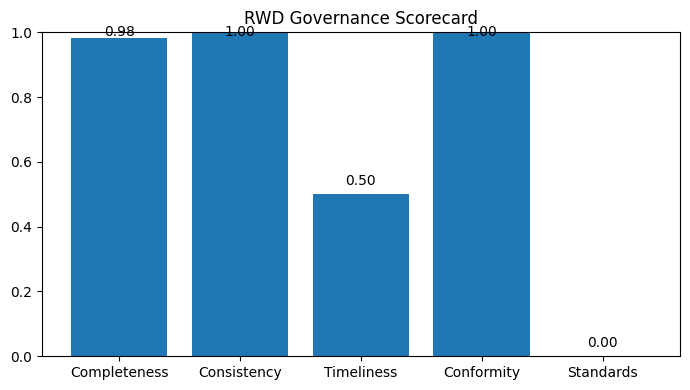

In [47]:
plot_scorecard(metrics)

#### Results interpretation table

In [71]:
import pandas as pd
from pathlib import Path

# ---- 1) Weights (edit if you’ve customized them in scripts/scorecard.py)
weights = {
    "completeness": 0.30,
    "consistency":  0.20,
    "timeliness":   0.20,
    "conformity":   0.15,
    "standards":    0.15,
}

# ---- 2) Explanations + “How to improve” tips
explanations = {
    "completeness": "Share of required fields populated (missingness).",
    "consistency":  "Internal checks: duplicate IDs, parsable dates, valid values.",
    "timeliness":   "How recent the records are vs today.",
    "conformity":   "Do records match expected schema/types for required fields?",
    "standards":    "Alignment to controlled vocabularies/models (MedDRA, ISO, OMOP/FHIR).",
}

improvements = {
    "completeness": "Backfill required fields, set source-level null thresholds, add extraction QA.",
    "consistency":  "Deduplicate by primary key, coerce date formats, validate value ranges.",
    "timeliness":   "Narrow to last 60–90 days, or use fresher feeds (EHR/claims/CDC).",
    "conformity":   "Harden parsers, enforce schema contracts, add row-level validators.",
    "standards":    "Map reactions to MedDRA, countries to ISO-3166, drugs to RxNorm/ATC; add OMOP/FHIR checks.",
}

# ---- 3) Build table
rows = []
for k, v in metrics.items():
    w = weights.get(k, 0.0)
    rows.append({
        "Dimension": k.title(),
        "Score": float(v),
        "Weight": w,
        "Contribution": w * float(v),
        "What it means": explanations.get(k, ""),
        "How to improve": improvements.get(k, ""),
    })
tbl = pd.DataFrame(rows).sort_values("Dimension").reset_index(drop=True)

# Overall (weighted) row
overall_weighted = sum(weights.get(k, 0.0) * float(metrics.get(k, 0.0)) for k in weights)
overall_row = pd.DataFrame([{
    "Dimension": "Overall",
    "Score": overall_weighted,           # overall score already weighted
    "Weight": 1.0,                       # display convenience
    "Contribution": overall_weighted,    # same as Score here
    "What it means": "Weighted summary across dimensions.",
    "How to improve": "Address the lowest-scoring dimensions first; biggest ROI comes from high weight × low score.",
}])
tbl_with_overall = pd.concat([tbl, overall_row], ignore_index=True)

# ---- 4) Conditional formatting
def color_score(val):
    try:
        x = float(val)
    except Exception:
        return ""
    if x < 0.70:
        return "background-color:#fde2e1; color:#8a0f0a;"   # red
    if x < 0.90:
        return "background-color:#fff4cc; color:#7a5a00;"   # amber
    return "background-color:#e6f4ea; color:#0b5f2a;"       # green

styled = (
    tbl_with_overall
      .style
      .format({"Score": "{:.2f}", "Weight": "{:.2f}", "Contribution": "{:.2f}"})
      .applymap(color_score, subset=["Score"])
)

display(styled)

# ---- 5) Save for reporting
Path("data").mkdir(exist_ok=True)
tbl_with_overall.to_csv("data/governance_scorecard_interpretation_weighted.csv", index=False)
print("Saved data/governance_scorecard_interpretation_weighted.csv")


/var/folders/13/7kvdx7rd1n317sj3gbz9yt6w0000gn/T/ipykernel_34241/2498411132.py:72: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_score, subset=["Score"])


,Dimension,Score,Weight,Contribution,What it means,How to improve
0,Completeness,0.98,0.30,0.30,Share of required fields populated (missingness).,"Backfill required fields, set source-level null thresholds, add extraction QA."
1,Conformity,1.00,0.15,0.15,Do records match expected schema/types for required fields?,"Harden parsers, enforce schema contracts, add row-level validators."
2,Consistency,1.00,0.20,0.20,"Internal checks: duplicate IDs, parsable dates, valid values.","Deduplicate by primary key, coerce date formats, validate value ranges."
3,N,499.00,0.00,0.00,,
4,Timeliness,0.50,0.20,0.10,How recent the records are vs today.,"Narrow to last 60–90 days, or use fresher feeds (EHR/claims/CDC)."
5,Overall,0.75,1.00,0.75,Weighted summary across dimensions.,Address the lowest-scoring dimensions first; biggest ROI comes from high weight × low score.


Saved data/governance_scorecard_interpretation_weighted.csv


## 5) Save artifacts (optional)

Cache raw JSON and the flattened CSV locally to `data/`.


In [62]:
Path('data').mkdir(exist_ok=True)
(Path('data') / 'openfda_sample.json').write_text(json.dumps(payload, indent=2))
df.to_csv('data/openfda_flat.csv', index=False)
reactions_df.to_csv('data/openfda_reactions_long.csv', index=False)
drugs_df.to_csv('data/openfda_drugs_long.csv', index=False)
print('Saved: data/openfda_sample.json, data/openfda_flat.csv, openfda_reactions_long.csv, openfda_drugs_long.csv')

Saved: data/openfda_sample.json, data/openfda_flat.csv, openfda_reactions_long.csv, openfda_drugs_long.csv


## Next steps
- Extend metrics: OMOP/FHIR conformity checks, vocabulary coverage (RxNorm, SNOMED), negative controls.
- Add jurisdiction-aware compliance flags (e.g., GDPR, HIPAA proxies).
- Create a portfolio dashboard comparing multiple sources/time windows.
